In [187]:
pip install wordsegment

In [189]:
import numpy as np
import pandas as pd
import torch
from hyperopt.pyll.base import scope 
import re
import matplotlib.pyplot as plt
from hyperopt import hp, tpe, fmin, Trials
from collections import Counter
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.metrics import confusion_matrix, classification_report
import csv
import sys
from wordsegment import segment, load
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import os
import random
from nltk.tokenize import TweetTokenizer
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split, ConcatDataset, WeightedRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [190]:
# ----------------- build labels and text ------------------
def remove_empty(text, label):
  indices = []
  for i in range(len(text)):
      if not text[i]:
        indices.append(i)
  if indices:
    text = np.delete(text, indices).tolist()
    label = np.delete(label, indices)
  return text, label

def concat_data(id2entities):
    text_train = id2entities['text_train']
    text_val = id2entities['text_test']
    label_dict = id2entities['label_dict']
    label_train = id2entities['label_train']
    label_val = id2entities['label_test']
    num_classes = len(label_dict)
    label_train = np.nonzero(label_train)[1]
    label_val = np.nonzero(label_val)[1]
    text_train, label_train = remove_empty(text_train, label_train)
    text_val, label_val = remove_empty(text_val, label_val)
    return text_train, text_val, label_train, label_val, label_dict

In [191]:
# ----------------- pre-process text ------------------

def text_preprocess(text, tknzr):
    FLAGS = re.MULTILINE | re.DOTALL
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code is less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    text = re_sub(r"#\S+", lambda hashtag: " ".join(segment(hashtag.group()[1:]))) # segment hastags
    tokens = tknzr.tokenize(text.lower())
    return " ".join(tokens)


In [192]:
# ----------------- build dictionary ------------------

def build_dict(corp, mode):
  wordcount = dict()
  wordcount['<pad>'] = len(wordcount)

  for ss in corp:   # for all sentences
      if mode!= 'char':
        words = ss.strip().lower().split()
        for w in words:  # for all words in a sentence      
          if w not in wordcount:
              wordcount[w] = len(wordcount)
      else:
        for char in list(ss.strip().lower()):
          if char not in wordcount:
            wordcount[char] = len(wordcount)
      
  return(wordcount)

In [193]:
# ----------------- convert text into list of index mapping using dictionary ------------------

def grab_data(_text, dictionary, sentence_length, mode):
    """
    Args:
        _text (list(string)): list of comments
        dictionary (dict): vocab in (word: frequency) format

    Returns:
        word_vectors (list(list(int))): list of sentences converted to list of word vectors
    """

    sentences = []
    sequence_length = []
    for ss in _text:
        if mode!= 'char':
          words = ss.strip().lower().split()[:sentence_length]
        else:
          words = list(ss.strip().lower())[:sentence_length]
        sentence = [dictionary[w] if w in dictionary else 1 for w in words]
        sequence_length.append(len(sentence))
        sentence += [0] * (sentence_length - len(sentence))
        # words: is a list containing the words in the sentence.
        sentences.append(sentence)
        
    return sentences, sequence_length

In [194]:
# ----------------- calculate weights for weighted sampler ----------------

def make_weights_for_balanced_classes(nclasses):                        
    count=Counter(nclasses)
    class_count=np.array([count[i] for i in count])
    weight=1./class_count
    return weight 

In [195]:
# ----------------- generate weighted random sampler for stratified batches ----------------

def generate_weighted_sampler(dataset):
    weights = make_weights_for_balanced_classes(dataset.labels)
    weights = torch.DoubleTensor(weights)
    samples_weight = np.array([weights[t] for t in dataset.labels])
    return WeightedRandomSampler(samples_weight, len(samples_weight))

In [196]:

# ----------------- load and split data ----------------

with open('train_path.txt') as f:
    args = f.readline().strip().split()
    train_path = args[0]
    mode = args[2]
    
    
data = pd.read_pickle(train_path)
text_train, text_val, label_train, label_val, label_dict = concat_data(data)

for i in range(len(text_train)):
  if not text_train[i]:
    print(i)

word_dict = build_dict(text_train + text_val, mode)


In [197]:
print(label_dict)

{'not_offensive': 0, 'offensive': 1}


In [198]:
def freq_count(labels):
  (unique, counts) = np.unique(labels, return_counts=True)
  frequencies = np.asarray((unique, counts)).T
  print(frequencies,"\n")
print("Train Label Frequencies: ")
freq_count(label_train)
print("Validation Label Frequencies: ")
freq_count(label_val)

Train Label Frequencies: 
[[    0 43080]
 [    1 25692]] 

Validation Label Frequencies: 
[[    0 10771]
 [    1  6423]] 



In [199]:
# ----------------- Custom Dataset ----------------

class AbusiveLanguageDetection(Dataset):
    """Abusive Language Detection."""
    
    def __init__(self, _text, _label, word_dict, sentence_length, mode):
        """
        Args:
            _text (list(string)): list of comments
            _label (integer): labels in range 0 - 2
        """
        self.text, self.sequence_length = grab_data(_text, word_dict, sentence_length, mode)
        self.labels = _label
        self.length = len(self.text)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return torch.tensor(self.text[idx]), torch.tensor(self.labels[idx], dtype=torch.int64), self.sequence_length[idx]

In [216]:
# ----------------- Prepare Data Loaders ----------------

batch_size = 32
sentence_length = 100
train_dataset = AbusiveLanguageDetection(text_train, label_train, word_dict, sentence_length, mode)
val_dataset = AbusiveLanguageDetection(text_val, label_val, word_dict, sentence_length, mode)
train_sampler = generate_weighted_sampler(train_dataset)
val_sampler = generate_weighted_sampler(val_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)

In [201]:
# ----------------- Define Model ----------------

class LSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, sentence_size, tagset_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True)
        self.hidden2hidden = nn.Linear(hidden_dim, sentence_size)
        self.relu = nn.ReLU()
        self.hidden2tag = nn.Linear(sentence_size, tagset_size)
        self.dropout = nn.Dropout(0.33)

    def forward(self, sentence, lengths):
        embeds = self.word_embeddings(sentence)
        embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (hn, cn) = self.lstm(embeds)
        classifier = self.hidden2hidden(hn[-1,:,:])
        classifier = self.relu(self.dropout(classifier))
        tag_scores = self.hidden2tag(classifier)
        return tag_scores

In [202]:
# ----------------- Define Training ----------------

def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels, sequence_length in dataloader:
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images, sequence_length)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels, sequence_length in dataloader:
        images,labels = images.to(device),labels.to(device)
        output = model(images, sequence_length)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [217]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
embedding_dim = 300
num_epochs = 10
hidden_dim = 298
learning_rate = 0.002
vocab_size = len(word_dict)
tagset_size = len(label_dict)

In [204]:
# ----------------- Train ----------------
model = LSTM(embedding_dim, hidden_dim, vocab_size + 1, 200, tagset_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion_weight = torch.FloatTensor(make_weights_for_balanced_classes(train_dataset.labels)).to(device)
criterion = nn.CrossEntropyLoss()
history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
max_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
    val_loss, val_correct=valid_epoch(model,device,val_loader,criterion)
    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    val_loss = val_loss / len(val_loader.sampler)
    val_acc = val_correct / len(val_loader.sampler) * 100
    if val_loss < max_val_loss:
        max_val_loss = val_loss
        print("Validation Loss has Decreased")
        torch.save(model,'LSTM.pt')

    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Validation Loss:{:.3f} AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                        num_epochs,
                                                                                                        train_loss,
                                                                                                        val_loss,
                                                                                                        train_acc,
                                                                                                        val_acc))
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

Validation Loss has Decreased
Epoch:1/10 AVG Training Loss:0.375 AVG Validation Loss:0.256 AVG Training Acc 83.77 % AVG Validation Acc 92.49 %
Epoch:2/10 AVG Training Loss:0.270 AVG Validation Loss:0.287 AVG Training Acc 90.86 % AVG Validation Acc 92.78 %
Validation Loss has Decreased
Epoch:3/10 AVG Training Loss:0.254 AVG Validation Loss:0.227 AVG Training Acc 91.63 % AVG Validation Acc 94.20 %
Validation Loss has Decreased
Epoch:4/10 AVG Training Loss:0.247 AVG Validation Loss:0.200 AVG Training Acc 91.96 % AVG Validation Acc 94.64 %
Epoch:5/10 AVG Training Loss:0.240 AVG Validation Loss:0.206 AVG Training Acc 92.23 % AVG Validation Acc 94.42 %
Epoch:6/10 AVG Training Loss:0.236 AVG Validation Loss:0.212 AVG Training Acc 92.38 % AVG Validation Acc 94.50 %
Epoch:7/10 AVG Training Loss:0.228 AVG Validation Loss:0.214 AVG Training Acc 92.66 % AVG Validation Acc 94.20 %
Epoch:8/10 AVG Training Loss:0.230 AVG Validation Loss:0.260 AVG Training Acc 92.54 % AVG Validation Acc 92.72 %
Epoch:

In [206]:
# ----------------- Evaluate ----------------

def evaluation(model, data_loader, label_dict):
  pred_y = []
  true_y = []
  val_correct = 0
  model.eval()
  for images, labels, sequence_length in data_loader:
    images,labels = images.to(device),labels.to(device)
    output = F.log_softmax(model(images, sequence_length), dim=1)
    scores, predictions = torch.max(output.data,1)
    pred_y += predictions.tolist()
    true_y += labels.tolist()
    val_correct+=(predictions == labels).sum().item()
  cm = confusion_matrix(true_y, pred_y)
  print(classification_report(true_y, pred_y, target_names = label_dict.keys(), digits=5))
  print("Confusion Matrix: \n", cm)



In [207]:
model = torch.load('LSTM.pt')
evaluation(model, val_loader, label_dict)

               precision    recall  f1-score   support

not_offensive    0.95298   0.96657   0.95973     12624
    offensive    0.90387   0.86827   0.88571      4570

     accuracy                        0.94044     17194
    macro avg    0.92843   0.91742   0.92272     17194
 weighted avg    0.93993   0.94044   0.94006     17194

Confusion Matrix: 
 [[12202   422]
 [  602  3968]]


# BILSTM

In [219]:
# ----------------- Define Model ----------------

class BLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, sentence_size, tagset_size):
        super(BLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, batch_first = True, bidirectional = True)
        self.hidden2hidden = nn.Linear(hidden_dim, sentence_size)
        self.relu = nn.ReLU()
        self.hidden2tag = nn.Linear(sentence_size, tagset_size)
        self.dropout = nn.Dropout(0.33)

    def forward(self, sentence, lengths):
        embeds = self.word_embeddings(sentence)
        embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (hn, cn) = self.lstm(embeds)
        hn = self.dropout(hn)
        classifier = self.hidden2hidden(torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1))
        classifier = self.relu(self.dropout(classifier))
        tag_scores = self.hidden2tag(classifier)
        return tag_scores

In [ ]:
# ----------------- Train ----------------

embedding_dim = 300
num_epochs = 10
hidden_dim = 400
learning_rate = 0.002
vocab_size = len(word_dict)
tagset_size = len(label_dict)
blstm_model = BLSTM(embedding_dim, hidden_dim, vocab_size + 1, 200, tagset_size)
blstm_model.to(device)
optimizer = optim.Adam(blstm_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
max_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss, train_correct=train_epoch(blstm_model,device,train_loader,criterion,optimizer)
    val_loss, val_correct=valid_epoch(blstm_model,device,val_loader,criterion)
    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    val_loss = val_loss / len(val_loader.sampler)
    val_acc = val_correct / len(val_loader.sampler) * 100
    if val_loss < max_val_loss:
        max_val_loss = val_loss
        print("Validation Loss has Decreased")
        torch.save(blstm_model,'BLSTM.pt')

    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Validation Loss:{:.3f} AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                        num_epochs,
                                                                                                        train_loss,
                                                                                                        val_loss,
                                                                                                        train_acc,
                                                                                                        val_acc))
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

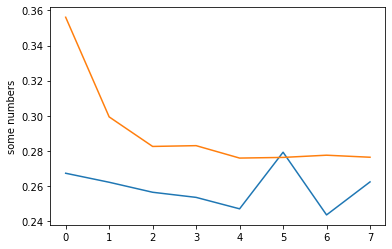

In [221]:
plt.plot(history['val_loss'])
plt.plot(history['train_loss'])
plt.ylabel('some numbers')
plt.show()

In [225]:
blstm_model = torch.load('BLSTM.pt')
evaluation(blstm_model, val_loader, label_dict)

               precision    recall  f1-score   support

not_offensive    0.94864   0.96373   0.95613     12765
    offensive    0.89044   0.84963   0.86956      4429

     accuracy                        0.93434     17194
    macro avg    0.91954   0.90668   0.91284     17194
 weighted avg    0.93365   0.93434   0.93383     17194

Confusion Matrix: 
 [[12302   463]
 [  666  3763]]
